In [1]:
import numpy as np
from numpy import random
import time
#from QfromPackage.func_block_lib_no_numpy import Qfrom as Qfrom_nn
from QfromPackage.Qfrom_mod import Qfrom
import pandas as pd
from math import sqrt
from collections.abc import Iterable

In [42]:
test_list = Qfrom()

In [3]:
def obj_test_get_data(n):
    name_list = ['Ann', 'Steven', 'Max', 'Jack', 'Julia', 'Clara', 'Emma', 'Bob', 'Anna' 'Lena']
    job_list = ['manager', 'freelancer', 'employee', 'artist', 'jobless', 'technician', 'boss', 'polician']
    max_age = 100

    name_ran_list = random.randint(len(name_list), size=n)
    age_ran_list = random.randint(max_age, size=n)
    job_ran_list = random.randint(len(job_list), size=n)

    data = [{
            'name': name_list[name_ran_list[i]],
            'age': age_ran_list[i],
            'job': job_list[job_ran_list[i]],
        } for i in range(n)]
    return data

In [4]:
def run_performence_test(test_list):
    #print('hallo')
    result_data = Qfrom()
    
    for test in test_list:
        test_name = test['test_name']
        data_gen_func = test['data_source_func']
        data_size_list = test['data_size_list']
        item_name_list = test['item_name_list']
        item_setup_list = test['item_setup_list']
        item_func_list = test['item_func_list']

        #print('start: ', test_name)
        data_sets = [data_gen_func(size) for size in data_size_list]
        for item_name, setup, func in zip(item_name_list, item_setup_list, item_func_list):
            #print('\t', item_name)
            for i in np.arange(len(data_size_list)):
                data = setup(data_sets[i])

                start_time = time.time()
                result = func(data)
                delta_time = time.time() - start_time
                
                if isinstance(result, Iterable):
                    result = len(result)
                result_data.add({'test_name': test_name, 'item_name': item_name, 'data_size': data_size_list[i], 'delta_time': delta_time, 'result': result})

                #print('\t\tdata_size: ', data_size_list[i], '; delta_time: ', delta_time)

            #print('\t', item_name, ' finished')

    return result_data

In [5]:
def get_data_size_tab(qfrom:Qfrom, test_name) -> Qfrom:
            #.where('test_name=="'+test_name+'"')\
    return qfrom\
            .where(lambda x:x['test_name']==test_name)\
            .group_by('data_size')\
            .select(lambda x: {'data_size':x['key'], **{item['item_name']:item['delta_time'] for item in x['value']}})\
            .order_by('data_size')

def print_max_stats(qfrom:Qfrom, compareable='np'):
        max_row = qfrom.max('data_size')
        print('data_size:', max_row['data_size'])
        for key, value in max_row.items():
                if key == 'data_size':
                        continue
                comp = max_row[compareable]
                percent = 0 if comp==0 else value/comp
                print('\t', key, '\t', round(value, 3), 's\t', str(round(percent, 3))+'%')

In [6]:
# set up funcs
def setup_np(data):
    return np.array(data)
def setup_tab_np(data):
    #col_dict = dict()
    #for key in data[0]:
    #    col_dict[key] = np.array([row[key] for row in data])
    return {key:np.array([row[key] for row in data]) for key in data[0]}
def setup_tuple_num_np(data):
    arr = np.array(data[0])
    return (arr, *data[1:])

def setup_num_array_df(data):
    return pd.DataFrame(data, columns=['numbers'])
def setup_dict_array_df(data):
    return pd.DataFrame(data)
def setup_tuple_num_df(data):
    df = pd.DataFrame(data[0], columns=['numbers'])
    return (df, *data[1:])

def setup_q(data):
    return Qfrom(data)
def setup_tuple_num_q(data):
    q = Qfrom(data[0])
    return (q, *data[1:])

In [7]:
# num test
def num_test_np(arr):
    pow_num = lambda num: num**2
    pow_num = np.frompyfunc(pow_num, 1, 1)
    arr = pow_num(arr)
    arr = arr[arr < 100]
    return arr

def num_test_df(df):
    df['numbers'] = df['numbers'].map(lambda x:x**2)
    df = df[df.numbers < 100]
    return df

def num_test_q(q):
    return q.select('x:x**2')\
            .where('x:x<100')()

#test_list.add({
#    'test_name': 'num test',
#    'data_source_func': lambda n: random.randint(100, size=n),
#    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
#    'item_name_list': ['np', 'df', 'q'],
#    'item_setup_list': [setup_np, setup_num_array_df, setup_q],
#    'item_func_list': [num_test_np, num_test_df, num_test_q]
#    })

In [8]:
# pow test
def pow_test_np(arr):
    arr = arr**2
    return arr

def pow_test_df(df):
    df['numbers'] = df['numbers']**2
    return df

def pow_test_q(q):
    return q**2

test_list.add({
    'test_name': 'pow test',
    'data_source_func': lambda n: random.randint(100, size=n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5, 5*10**6, 5*10**7],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_num_array_df, setup_q],
    'item_func_list': [pow_test_np, pow_test_df, pow_test_q]
    })

In [9]:
# object type test
def obj_test_np(col_dict):
    filter_job = lambda x:x["job"]=="manager"
    filter_job = np.frompyfunc(filter_job, 1, 1)

    age_filter = np.where(col_dict['age']<50)
    col_dict = {key: value[age_filter] for key, value in col_dict.items()}
    
    col_dict['name'] = np.char.upper(col_dict['name'])

    job_filter = np.where(col_dict['job']=='manager')
    col_dict = {key: value[job_filter] for key, value in col_dict.items()}
    
    #return [{key: value[i] for key, value in col_dict.items()} for i in np.arange(col_dict['name'].size)]
    return col_dict

def obj_test_df(df):
    df = df[df['age'] < 50]
    df['name'] = df['name'].apply(lambda x:x.upper())
    #df['name'] = df['name'].map(lambda x:x.upper())
    df = df[df['job']=='manager']
    return df

def obj_test_q(q):
    return q.where('age<50')\
            .select(lambda x: {**x, 'name':x['name'].upper()})\
            .where('job=="manager"')()

#test_list.add({
#    'test_name': 'object type test',
#    'data_source_func': lambda n: obj_test_get_data(n),
#    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
#    'item_name_list': ['np', 'df', 'q'],
#    'item_setup_list': [setup_tab_np, setup_dict_array_df, setup_q],
#    'item_func_list': [obj_test_np, obj_test_df, obj_test_q]
#    })

In [10]:
# test order by
def order_by_test_np(arr):
    return np.sort(arr)

def order_by_test_df(df):
    return df.sort_values('numbers')

def order_by_test_q(q):
    return q.order_by()()

test_list.add({
    'test_name': 'order by test',
    'data_source_func': lambda n: random.randint(10000, size=n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5, 5*10**6],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_num_array_df, setup_q],
    'item_func_list': [order_by_test_np, order_by_test_df, order_by_test_q]
    })

In [11]:
# obj order by
'''def obj_order_by_test_np(arr):
    key_func = np.frompyfunc(lambda x:x["age"], 1, 1)
    key_array = key_func(arr)
    sorted_ids = np.argsort(key_array)
    arr = arr[sorted_ids]
    return arr'''
def obj_order_by_test_np(col_dict):
    key_array = col_dict['age']
    sorted_ids = np.argsort(key_array)
    return {key:value[sorted_ids] for key, value in col_dict.items()}

def obj_order_by_test_df(df):
    return df.sort_values('age')

def obj_order_by_test_q(q):
    return q.order_by('age')()

test_list.add({
    'test_name': 'obj order by test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    #'item_setup_list': [setup_np, setup_dict_array_df, setup_q],
    'item_setup_list': [setup_tab_np, setup_dict_array_df, setup_q],
    'item_func_list': [obj_order_by_test_np, obj_order_by_test_df, obj_order_by_test_q]
    })

In [12]:
# test multi processing

def sim_complex_operation(item):
    #delay = 10**(-9)
    delay = 10**2
    #time.sleep(sleep_time_sek)
    sum = 0
    for i in range(delay):
        sum += 1
    return item

def mult_proc_test_q(data):
    return Qfrom(data)\
        .select(sim_complex_operation)\
        .order_by()\
        .select(sim_complex_operation)\
        .to_list()

def mult_proc_test_q_p(data):
    return Qfrom(data)\
        .select(sim_complex_operation)\
        .order_by()\
        .select(sim_complex_operation)\
        .as_parallel()\
        .to_list()

#test_list.add({
#    'test_name': 'multi processing test',
#    'data_source_func': lambda n: random.randint(10000, size=n),
#    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4],
#    'item_name_list': ['q', 'q_p'],
#    'item_func_list': [mult_proc_test_q, mult_proc_test_q_p]
#    })

In [13]:
# test any worst case
def any_test_np(arr):
    return arr.any()

def any_test_df(df):
    return df.any()

def any_test_q(q):
    return q.any()

test_list.add({
    'test_name': 'any worst case test',
    'data_source_func': lambda n: np.full(n, 0),
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5, 5*10**6, 5*10**7],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_num_array_df, setup_q],
    'item_func_list': [any_test_np, any_test_df, any_test_q]
})

In [14]:
# test any with predicate
def any_predicate_test_np(arr):
    pred_func = np.frompyfunc(lambda x:x['name']=='Carl', 1, 1)
    return pred_func(arr).any()

def any_predicate_test_df(df):
    return df['name'].apply(lambda x:x=='Carl').any()

def any_predicate_test_q(q):
    return q.any('name=="Carl"')

test_list.add({
    'test_name': 'any with predicate worst case test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_dict_array_df, setup_q],
    'item_func_list': [any_predicate_test_np, any_predicate_test_df, any_predicate_test_q]
})

In [15]:
# random access test
def ranacc_test_np(t):
    arr, ids = t

    test_sum = 0
    for id in ids:
        test_sum = arr[id]
    return test_sum

def ranacc_test_df(t):
    df, ids = t

    test_sum = 0
    for id in ids:
        test_sum = df.iloc[id]
        #test_sum = df.values[id]
    return test_sum

def ranacc_test_q(t):
    q, ids = t
    
    test_sum = 0
    for id in ids:
        test_sum = q[id]
    return test_sum

data_size = 10**7
test_list.add({
    'test_name': 'random access test',
    'data_source_func': lambda n: (random.randint(100, size=data_size), random.randint(data_size, size=n)),
    #'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_tuple_num_np, setup_tuple_num_df, setup_tuple_num_q],
    'item_func_list': [ranacc_test_np, ranacc_test_df, ranacc_test_q]
})

In [16]:
# test agg
#def agg_test_q_nn(data):
#    return Qfrom_nn(data).agg('a,b:a+b')

def agg_test_q(data):
    return Qfrom(data).agg('a,b:a+b')

In [17]:
# test select columns
'''def select_col_test_np(arr):
    select_name_age = lambda x: {'name':x['name'], 'age':x['age']}
    select_name_age = np.frompyfunc(select_name_age, 1, 1)

    arr = select_name_age(arr)
    return arr'''
def select_col_test_np(col_dict):
    return {key:value for key, value in col_dict.items() if key in ['name', 'age']}

def select_col_test_df(df):
    return df[['name', 'age']]

def select_col_test_q(q):
    return q.select('name, age')()

test_list.add({
    'test_name': 'select columns test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    #'item_setup_list': [setup_np, setup_dict_array_df, setup_q],
    'item_setup_list': [setup_tab_np, setup_dict_array_df, setup_q],
    'item_func_list': [select_col_test_np, select_col_test_df, select_col_test_q]
})

In [18]:
# test map
'''def map_test_np(arr):
    select_name_age = lambda x: {**x, 'age':x['age']+10}
    select_name_age = np.frompyfunc(select_name_age, 1, 1)

    arr = select_name_age(arr)
    return arr'''
def map_test_np(col_dict):
    map_age = np.frompyfunc(lambda x: x+10, 1, 1)
    return {**col_dict, 'age':map_age(col_dict['age'])}

def map_test_df(df):
    df['age'] = df['age'].map(lambda x: x+10)
    return df

def map_test_q(q):
    #return q.edit_column('age', lambda x: x['age']+10)()
    return q.select(lambda x: {**x, 'age':x['age']+10})()

test_list.add({
    'test_name': 'map test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_tab_np, setup_dict_array_df, setup_q],
    'item_func_list': [map_test_np, map_test_df, map_test_q]
})

In [19]:
# test where
def where_col_test_np(col_dict):
    job_filter = np.where(col_dict['job']=='manager')
    col_dict = {key: value[job_filter] for key, value in col_dict.items()}
    return col_dict

def where_col_test_df(df):
    return df[df['job']=='manager']

def where_col_test_q(q):
    return q.where('job=="manager"')()

test_list.add({
    'test_name': 'where test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_tab_np, setup_dict_array_df, setup_q],
    'item_func_list': [where_col_test_np, where_col_test_df, where_col_test_q]
})

In [20]:
# test group by
def group_by_test_np(arr):
    select_job = lambda x: x['job']
    select_job = np.frompyfunc(select_job, 1, 1)

    job_col = select_job(arr)
    #unique_jobs = np.unique(job_col)
    
    #result_arr = np.empty(unique_jobs.size, dtype=object)
    #for i in np.arange(unique_jobs.size):
    #    filter_job = job_col == unique_jobs[i]
    #    result_arr[i] = {'key': unique_jobs[i], 'value': arr[filter_job]}

    #return result_arr

    sorted_ids = job_col.argsort()
    sorted_arr = arr[sorted_ids]
    unique_jobs = np.unique(job_col[sorted_ids], return_index=True)
    groups = np.split(sorted_arr, unique_jobs[1][1:])

    func = lambda a, b: {'key':a, 'value':b}
    func = np.frompyfunc(func, 2, 1)
    #return np.array(func(unique_jobs[0], groups), dtype=object)
    return func(unique_jobs[0], groups)


def group_by_test_df(df):
    return df.groupby(['job'])

def group_by_test_q(q):
    return q.group_by('job')()

test_list.add({
    'test_name': 'group by test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_dict_array_df, setup_q],
    'item_func_list': [group_by_test_np, group_by_test_df, group_by_test_q]
})

In [21]:
# test iter rows
def iter_rows_test_np(arr):
    row_count = 0
    for row in arr:
        row_count += 1
    return row_count

def iter_rows_test_df(df):
    row_count = 0
    #for row in df.iterrows():
    for row in df.values:
        row_count += 1
    return row_count

def iter_rows_test_q(q):
    row_count = 0
    for row in q:
        row_count += 1
    return row_count

test_list.add({
    'test_name': 'iter rows test',
    'data_source_func': lambda n: obj_test_get_data(n),
    #'data_size_list': [10**2, 10**3, 10**4, 10**5, 10**6] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4],
    'item_name_list': ['np', 'df', 'q'],
    'item_setup_list': [setup_np, setup_dict_array_df, setup_q],
    'item_func_list': [iter_rows_test_np, iter_rows_test_df, iter_rows_test_q]
})

In [22]:
# test combine selects
def combine_selects_single(q):
    return q.select(lambda x:{**x, 'age':x['age']*10})\
            .select(lambda x:{**x, 'age':x['age']+1})\
            .select(lambda x:{**x, 'age':x['age']/10})\
            .select(lambda x:{**x, 'age':x['age']*10})\
            .select(lambda x:{**x, 'age':x['age']+1})\
            .select(lambda x:{**x, 'age':x['age']/10})\
            ()

def combined_func(x):
    compined_op_output = x
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']*10}
        break
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']+1}
        break
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']/10}
        break
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']*10}
        break
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']+1}
        break
    while True:
        compined_op_output = {**compined_op_output, 'age':compined_op_output['age']/10}
        break
    return compined_op_output

def combine_selects_combined(q):
    #return q.select(lambda x:{**x, 'age':((x['age']*10) +1) /10})()
    return q.select(lambda x:combined_func(x))()

test_list.add({
    'test_name': 'combine selects test',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['single', 'combined'],
    'item_setup_list': [setup_q, setup_q],
    'item_func_list': [combine_selects_single, combine_selects_combined]
})

In [43]:
# test combine selects func call
def combine_selects_single(q):
    f1 = lambda x:{**x, 'age':x['age']*10}
    f2 = lambda x:{**x, 'age':x['age']+1}
    f3 = lambda x:{**x, 'age':x['age']/10}
    return q.select(f1)\
            .select(f2)\
            .select(f3)\
            .select(f1)\
            .select(f2)\
            .select(f3)\
            .select(f1)\
            .select(f2)\
            .select(f3)\
            .select(f1)\
            .select(f2)\
            .select(f3)\
            ()

def combine_selects_combined(q):
    f1 = lambda x:{**x, 'age':x['age']*10}
    f2 = lambda x:{**x, 'age':x['age']+1}
    f3 = lambda x:{**x, 'age':x['age']/10}
    return q.select(lambda x:f3(f2(f1(f3(f2(f1(f3(f2(f1(f3(f2(f1(x)))))))))))))()

test_list.add({
    'test_name': 'combine selects test func call',
    'data_source_func': lambda n: obj_test_get_data(n),
    'data_size_list': [10**2, 10**3, 10**4, 10**5] + [5*10, 5*10**2, 5*10**3, 5*10**4, 5*10**5],
    'item_name_list': ['single', 'combined'],
    'item_setup_list': [setup_q, setup_q],
    'item_func_list': [combine_selects_single, combine_selects_combined]
})

In [44]:
q_result = run_performence_test(test_list)

In [25]:
#g = q_result(get_data_size_tab, 'num test')
#g.plot(x='data_size', x_scale_log=True)#, y_scale_log=True)
#g(print_max_stats)

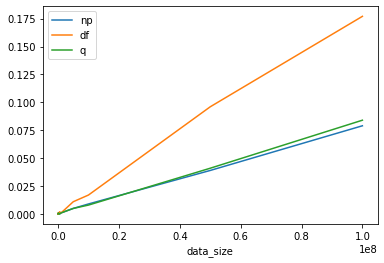

data_size: 100000000
	 np 	 0.079 s	 1.0%
	 df 	 0.177 s	 2.241%
	 q 	 0.084 s	 1.063%


In [26]:
g = q_result(get_data_size_tab, 'pow test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

In [27]:
#g = q_result(get_data_size_tab, 'object type test')
#g.plot(x='data_size', x_scale_log=True)#, y_scale_log=True)
#g(print_max_stats)

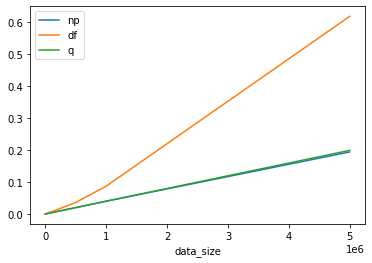

data_size: 5000000
	 np 	 0.194 s	 1.0%
	 df 	 0.618 s	 3.186%
	 q 	 0.199 s	 1.026%


In [28]:
g = q_result(get_data_size_tab, 'order by test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

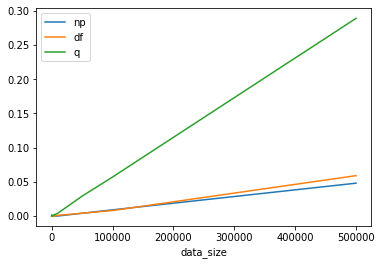

data_size: 500000
	 np 	 0.048 s	 1.0%
	 df 	 0.059 s	 1.229%
	 q 	 0.289 s	 6.021%


In [29]:
g = q_result(get_data_size_tab, 'obj order by test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

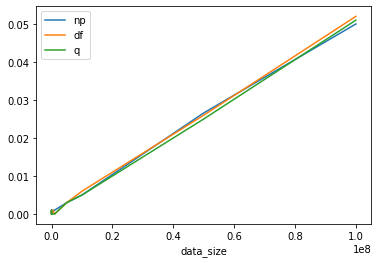

data_size: 100000000
	 np 	 0.05 s	 1.0%
	 df 	 0.052 s	 1.04%
	 q 	 0.051 s	 1.02%


In [30]:
g = q_result(get_data_size_tab, 'any worst case test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

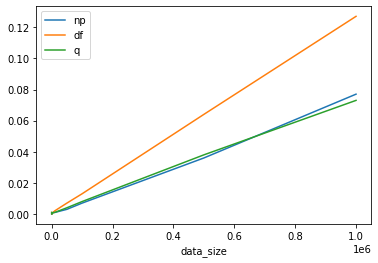

data_size: 1000000
	 np 	 0.077 s	 1.0%
	 df 	 0.127 s	 1.649%
	 q 	 0.073 s	 0.948%


In [31]:
g = q_result(get_data_size_tab, 'any with predicate worst case test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

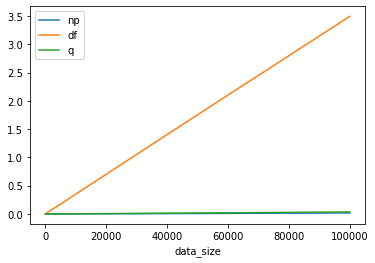

data_size: 100000
	 np 	 0.019 s	 1.0%
	 df 	 3.494 s	 183.857%
	 q 	 0.036 s	 1.895%


In [32]:
g = q_result(get_data_size_tab, 'random access test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

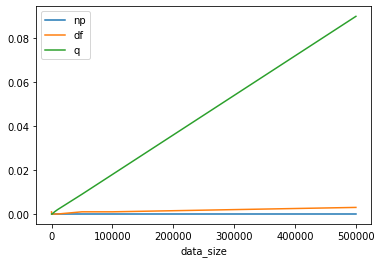

data_size: 500000
	 np 	 0.0 s	 0%
	 df 	 0.003 s	 0%
	 q 	 0.09 s	 0%


In [33]:
g = q_result(get_data_size_tab, 'select columns test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

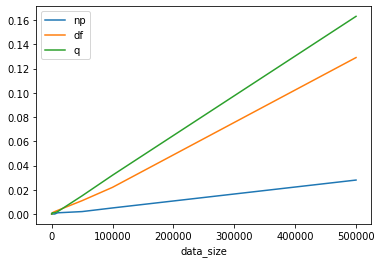

data_size: 500000
	 np 	 0.028 s	 1.0%
	 df 	 0.129 s	 4.607%
	 q 	 0.163 s	 5.821%


In [34]:
g = q_result(get_data_size_tab, 'map test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

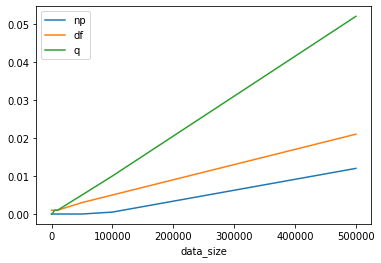

data_size: 500000
	 np 	 0.012 s	 1.0%
	 df 	 0.021 s	 1.75%
	 q 	 0.052 s	 4.334%


In [35]:
g = q_result(get_data_size_tab, 'where test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

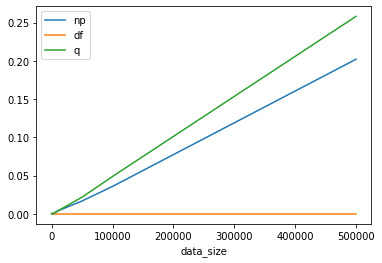

data_size: 500000
	 np 	 0.202 s	 1.0%
	 df 	 0.0 s	 0.0%
	 q 	 0.258 s	 1.277%


In [36]:
g = q_result(get_data_size_tab, 'group by test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

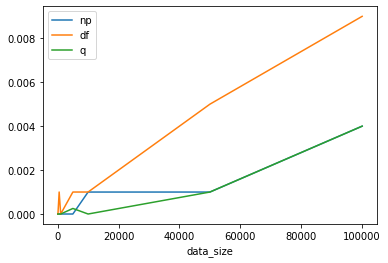

data_size: 100000
	 np 	 0.004 s	 1.0%
	 df 	 0.009 s	 2.25%
	 q 	 0.004 s	 1.0%


In [37]:
g = q_result(get_data_size_tab, 'iter rows test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats)

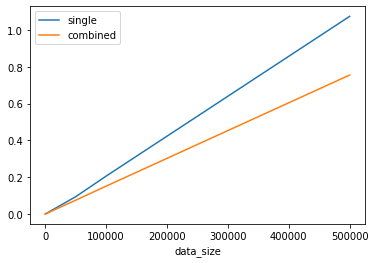

data_size: 500000
	 single 	 1.074 s	 1.0%
	 combined 	 0.755 s	 0.703%


In [38]:
g = q_result(get_data_size_tab, 'combine selects test')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats, 'single')

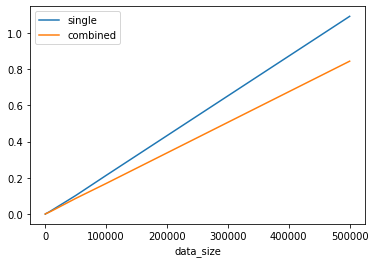

data_size: 500000
	 single 	 1.091 s	 1.0%
	 combined 	 0.843 s	 0.773%


In [45]:
g = q_result(get_data_size_tab, 'combine selects test func call')
g.plot(x='data_size')#, x_scale_log=True)#, y_scale_log=True)
g(print_max_stats, 'single')

In [40]:
# import/export list
data = obj_test_get_data(10**6)
start_time = time.time()
print(len(Qfrom(data).to_list()))
print(time.time()-start_time)

1000000
0.21805047988891602


In [41]:
# import/export dataframe
data = obj_test_get_data(10**6)
start_time = time.time()
q = Qfrom(pd.DataFrame(data))
print(time.time()-start_time)
start_time = time.time()
print(len(q.to_dataframe()))
print(time.time()-start_time)

1.324531078338623
1000000
0.4671058654785156
